We'll start with generating blobs of numbers and then interpreting them in interesting (?) ways.

Sometimes we'll just export the raw data, for later import into other applications, like Max or Supercollider, Processing, a spreadsheet, etc. When you store data in a text file, maybe as a CSV (Comma Seperated Values) file, it makes it really easy to then use that data in other applications. Almost any programming or production environment can use a text file for input data.

We'll also generate a bunch of MIDI files. This is not because we particularly want to work with MIDI files, but rather because it's a really quick way to hear what you've done. MIDI files are generic enough that you can play them back almost anywhere. You probaby won't make a finished piece by spitting out a MIDI file, but you can certainly start to assemble your materials that way. And of course any music application will be happy to open your MIDI file, allowing you to turn it into something not so dumb. 

Here's a list of MIDI General Instruments. PrettyMidi starts counting at zero, so subtract one from each instrument number...
http://www.midi.org/techspecs/gm1sound.php

We'll also generate some graphs, and even some scores! Whee!

We won't get to working with synthesis or samples yet. That's in the next notebook.


In [15]:
# basic imports

# this one lets us call external command line programs
from subprocess import Popen

# we'll need some random number generators
import random

# numpy is numerical python, lots of useful routines
# the "as np" means we can refer to this as np rather than numpy
# why? it's just a convention you'll see in lots of demo code, so we'll follow it as well
# plus we save typing three letters!
import numpy as np

# we wanna make plots like in Matlab!
# same idea, we can just type "plt" instead of the whole name
import matplotlib.pyplot as plt

#here's a simple midi library written by Collin in Dan Ellis's lab
#https://github.com/craffel/pretty-midi
import pretty_midi
import midi

# abjad is a lilypad scoring interface built by Victor Adan and friends
# http://abjad.mbrsi.org/
import abjad

# this tells the notebook to show us graphics inline
# this is only meaningful in iPython Notebook
# iPython commands that start with % are called "magics"
# this won't do anything in regular python
%matplotlib inline


This is how we're going to play back MIDI files. 

We'll create a method called, uh, play_midi_file() and we'll send it the name of a MIDI file we've just saved. It'll use a Python trick to send that filename to VLC via the command line. Here's how it would look if you typed it in the Terminal:

<code>douglas$ /Applications/VLC.app/Contents/MacOS/VLC -I dummy myfile.midi vlc://quit</code>

VLC is a nice application that can play almost anything. You have to have VLC installed and select a synth bank to play MIDI files. 

We'll also define a method called kill_midi(). Call that anytime you want VLC to stop playing the MIDI file you just sent it. Like if you generated 100,000 notes by mistake... It works by, again, using a Python trick to call a command line program. In this case it calles "killall", which kills whatever program you ask it to. We send it the name "VLC", and so it kills any copies of VLC it finds running. On the command line it would look like this:

<code>douglas$ killall VLC</code>

Finally we'll make an open_file(filename) method. This will be just like double-clicking on a file in a folder. We'll use it to look at text files. The OS will automatically open the text file in your default text file application.

<code>douglas$ open bleep.txt</code>


In [16]:

def play_midi_file(midi_filename):
    p = Popen(["/Applications/VLC.app/Contents/MacOS/VLC", "-I", "dummy", midi_filename, "vlc://quit"])

def kill_midi():
    # MAKE IT STOP!!!
    p = Popen(["killall", "VLC"])
    
def open_file(filename):
    p = Popen(["open", filename])

Since we're dealing with notes, maybe we want to call them by letter names. I generally find it easier to work with numbers at this stage, but there might be a reason you want to see note names. So for convenience, let's make a list of pitch class names.

In [3]:
#make a list of pitch class names
p_class_names = ['c', 'c#', 'd', 'd#', 'e', 'f', 'f#', 'g', 'g#', 'a', 'a#', 'b']

print p_class_names[0]
print p_class_names[0], p_class_names[4], p_class_names[7]
print p_class_names[-1]
print p_class_names[0:4]

for name in p_class_names:
    print name,


c
c e g
b
['c', 'c#', 'd', 'd#']
c c# d d# e f f# g g# a a# b


The dumbest, simplest thing to do now is generate some random note values. NO ONE WANTS TO LISTEN TO RANDOM NOTES!!! But here we are.

In [4]:
for note in range(10):
    # pick a number from 0 to 11
    note_num = random.randint(0,11)
    print p_class_names[note_num],


d# g# c g# d# g# b g a# c#


Let's add a randomly generated octave indication to our notes. And instead of just printing them, let's also save them in a text file.

In [5]:
# this time we need a list to store our notes in since we'll use them later
notes = []

for note in range(10):
    # pick a number from 0 to 11
    note_num = random.randint(0,11)
    oct_num = random.randint(0, 8)

    # combine note name and octave
    # there are other ways to build a string. I like this one.
    note_string = p_class_names[note_num] + str(oct_num)
    notes.append(note_string)

print notes

# store our filename in a variable so that we can refer to it later
file_name = "random_notes.txt"

# this will open our file for writing. we can refer to it as f.
with open(file_name, 'w') as f:
    
    f.write("zzz, here are some random notes:\n")
    
    for note in notes:
        f.write(note)
        f.write(", ")
        
    # make our text file prettier by ending with a new line
    f.write("\n")
        
    f.close()
    

open_file(file_name)

['d#8', 'c#2', 'f2', 'f3', 'd#5', 'f#6', 'f3', 'a2', 'd#7', 'c2']


Okay, if that was exciting then you're done. Otherwise, let's do something more interesting!

Maybe we want a LOT of notes in one octave. We want them in a normal distribution, which means they make a bell shape when we plot them. We want to pick which note should be the left-most in our distribution. 

In [6]:
normal_values = np.random.randn(10)
print normal_values
print min(normal_values)
print max(normal_values)

[-1.37832476 -0.20954918 -1.1530849  -0.26069557  0.14708788 -1.13718535
  1.01094313 -0.38753214 -0.15722205  1.47404417]
-1.37832476316
1.47404417319


In [7]:
# we'll define a method that we can call later

def gen_norm_pitch_dist(start_pitch_num = 0, num_pitches = 1000):
    
    #generate values with a normal (bell-shaped) distribution)
    normal_values = np.random.randn(num_pitches)


    normal_values = np.interp(normal_values,[normal_values.min(), normal_values.max()],[0,12])

    # we round them so that we have integers rather than floats
    normal_values = np.round(normal_values)
    
    #print normal_values
    
    # we shift them so that the starting pitch is at the left side of the bell curve
    normal_values += start_pitch_num

    # we do mod 12 so that our numbers are still from 0-11
    normal_values %= 12
    
    # technically they're still floats at this point. return them as ints.
    return normal_values.astype(int)
    
    '''
    #print normal_values
    
    low = min(normal_values)
    
    # let's shift the values so that they start at 0.0
    normal_values -= low
    
    #print normal_values
    
    high = max(normal_values)
    
    # we want to normalize so that the numbers go from 0-11
    multi = 11.0/high

    normal_values *= multi
    
    #print normal_values
    '''


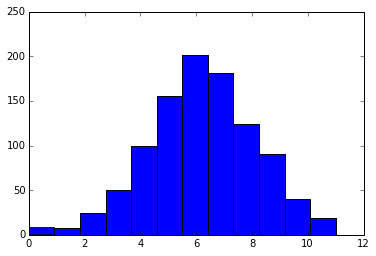

In [8]:
# get a big list of pitches

# which note do we want to start on? C = 0
# start on F, meaning we have very few F's
start_pitch = 0

# let's use the method we defined above to get 1000 pitches
pitches = gen_norm_pitch_dist(start_pitch, num_pitches = 1000)

# generate a histogram of the normal values. This will put them into 12 bins and generate a nice graphic of the distribution
counts, null, null = plt.hist(pitches,12)


In [9]:

#make a little chart of the pitch class names and how many of each we got
# zip takes two lists and lines them up, giving you pairs of elements, one from each list
for num, count in zip(range(12), counts):
    print p_class_names[num], "\t", count

#print the pitch class selections as numbers    
print pitches[:10]

#now print them with their pitch class names
for n in pitches[:10]:
    print p_class_names[n], 

c 	8.0
c# 	8.0
d 	24.0
d# 	50.0
e 	99.0
f 	156.0
f# 	201.0
g 	181.0
g# 	124.0
a 	90.0
a# 	40.0
b 	19.0
[ 9  4  6  4  3 10  7  3  3  2]
a e f# e d# a# g d# d# d


<Container object of 12 artists>

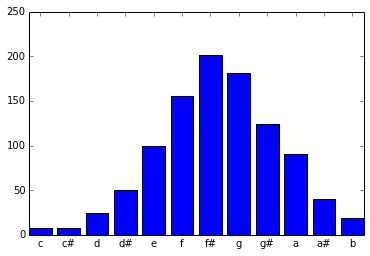

In [10]:
#make a bar graph showing us how many of each pitch class we got
plt.xticks(np.arange(0,12), p_class_names)
plt.bar(np.arange(0,12), counts, align='center')


In [11]:
#write them to a text file as MIDI note values around middle C (midi note 60)

filename = "normal_notes.txt"

with open(filename, 'w') as f:
    midi_note_offset = 60
    
    for note in pitches:
        trans_note_num = note + midi_note_offset
        #print "t_n_n: ", trans_note_num
        f.write(str(trans_note_num))
        f.write(", ")
        
        
    f.write("\n")
    f.close()


open_file(filename)

In [17]:
#that's cool, but what about making an actual MIDI file from the data?

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add a trumpet instrument
pm.instruments.append(pretty_midi.Instrument(56))

curr_time = 0.0
beat_duration = .1
note_duration = beat_duration * 0.9
# clustered around middle C
midi_note_offset = 60

times = []

for note in pitches:
    trans_note_num = note + midi_note_offset
    pm.instruments[0].notes.append(pretty_midi.Note(90, trans_note_num, curr_time, curr_time + note_duration))
    curr_time += beat_duration

# we'll use this filename to play back in a sec, so let's store it in a variable
midi_filename = "normal_dist.mid"
# write out the midi file. This file is for real and will work with any midi app!
pm.write(midi_filename)

#play it!
play_midi_file(midi_filename)



In [13]:
#MAKE IT STOP!!!
kill_midi()

In [18]:
# a little improv with cymbal...

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add a couple instruments
pm.instruments.append(pretty_midi.Instrument(20))
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

beats_per_second = 8
improv_duration = 10.0
num_beats = improv_duration * beats_per_second
beat_length = improv_duration / num_beats
# why use a multiplier here instead of just, say, subtracting 0.1 seconds?
note_length = beat_length * 0.75

# use np.arange to create a list of beat start times
for time in np.arange(0, improv_duration, beat_length):
    #just to prove to yourself that this works!
    #print "current time: ", time
    
    #pick a random midi note from 60-72 (middle C + an octave)
    note = random.randint(60,72);
    
    #append the note to our instrument's note list
    #Note arguments are volume, note number, start time, end time
    
    # maybe we don't always want a note. Use np.random.choice to decide...
    
    if np.random.choice([True, False]):
        pm.instruments[0].notes.append(pretty_midi.Note(90, note, time, time + note_length))
    
    #add a cymbal tick on each beat. Why not!?!
    # let's vary the volume a bit to give it some life
    volume = random.randint(70,110)
    pm.instruments[1].notes.append(pretty_midi.Note(volume, 42, time, time + note_length))

#we'll use this filename to play back in a sec, so let's store it in a variable
midi_filename = "improv.mid"
#write out the midi file. This file is for real and will work with any midi app!
pm.write(midi_filename)

#play it!
play_midi_file(midi_filename)



In [15]:
kill_midi()

In [16]:
# What about that Tom Johnson Chord Catalog piece? Let's do something like that!
# Let's play all 3-voice chords in an octave


# this is our starting note, middle C
base_note = 60
#this will keep track of where each of our three voices is
chord = [0,0,0]

# let's store all the chords to use later...
tj_chords = []

#how long is each beat
beat_duration = .1

#how long do we hold each chord? let's say it's half the beat duration
note_duration = beat_duration * 0.5

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add honky tonk piano
pm.instruments.append(pretty_midi.Instrument(3))
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

curr_time = 0.0

#uh, let's just do 2 or it'll play forever...
#for offset_0 in range(12):
for offset_0 in range(2):
    
    chord[0] = base_note + offset_0
    
    for offset_1 in range(12):
        chord[1] = base_note + offset_1
        
        for offset_2 in range(12):
            chord[2] = base_note + offset_2
            
            for n in range(3):
                #wiggle our volume, from 20-90
                volume = random.randint(20,90)

                #create our chord from our three chord[n] values
                #use curr_time as starting time and curr_time + our note duration for the stop time
                pm.instruments[0].notes.append(pretty_midi.Note(volume, chord[n], curr_time, curr_time + note_duration))
                volume = random.randint(70,110)
                pm.instruments[1].notes.append(pretty_midi.Note(volume, 42, curr_time, curr_time + note_length))
            #increment curr_time with beat_duration, not note_duration. This lets us play with articulation a bit
            curr_time += beat_duration
            
            # save for later
            # note that we make a copy of the chord each time
            # otherwise we're just saving a reference to the same chord structure and it'll replace the values every time!
            tj_chords.append(list(chord))

midi_filename = "all_chords.mid"
pm.write(midi_filename)

#play it!
play_midi_file(midi_filename)


In [17]:
kill_midi()

In [18]:
#let's mess up a perfectly good midi file

input_filename = "moonlight.mid"

# Construct PrettyMIDI object
pm = pretty_midi.PrettyMIDI("moonlight.mid")

c_counter = 0
c_mod_counter = 0

# Iterate over the instrument tracks in the MIDI file
for instrument in pm.instruments:
    # Check whether the instrument is a drum track
    if not instrument.is_drum:
        # Iterate over note events for this instrument
        # Enumerate gives us an index as well as the object
        for i,note in enumerate(instrument.notes):
            
            if note.pitch % 12 == 0:
                c_counter += 1
            #we'll just mess up every 5th note
            if i % 5 == 0:
                # Shift up by a half-step
                note.pitch += 1
            
            if note.pitch % 12== 0:
                c_mod_counter += 1
                
# Write out wonky version
name_parts = input_filename.split(".")
print "name_parts: ", name_parts
output_filename = name_parts[0] + "_wonky.mid"
print "output_filename: ", output_filename
pm.write(output_filename)

#play it!
play_midi_file(output_filename)

print ("here's how many c's:", c_counter)
print ("here's how many c mods:", c_mod_counter)

name_parts:  ['morph_melody', 'mid']
output_filename:  morph_melody_wonky.mid
("here's how many c's:", 64)
("here's how many c mods:", 74)


In [19]:
kill_midi()

I am Sam. I am Sam. Sam-I-Am.

That Sam-I-Am! That Sam-I-Am! I do not like that Sam-I-Am!

Do you like green eggs and ham?

I do not like them, Sam-I-Am.
I do not like green eggs and ham.

Would you like them here or there?

I would not like them here or there.
I would not like them anywhere.
I do not like green eggs and ham.
I do not like them, Sam-I-Am.




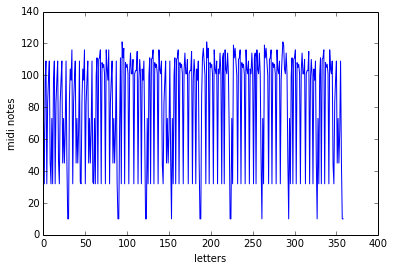

In [20]:
# How about something with text? Let's assign a note to each letter in the alphabet, then play texts through it!

def values_from_text(text):

    values = []

    for letter in text:
        # ord gets the ascii value of each letter
        # %127 makes sure we only get note numbers 0-127
        letter_value = ord(letter) % 127
        
        #add it to our list!
        values.append(letter_value)
    
    #we'll just return a list of values to be processed later...
    return values



#let's use it!

#our text can come from anywhere. 

#here we'll open a file and read in the text

f = open("seuss_green.txt", "r")
text_lines = f.readlines()
text = ""
for line in text_lines:
    text += line


#here we'll just type in some text directly
#text = "i like tacos. I like tacos. You like tacos. U like tacos."

# get letter values from the text
# we'll interpret them as MIDI note values, but they could be anything
notes = values_from_text(text)

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add banjo
pm.instruments.append(pretty_midi.Instrument(105))

#how long is each bleep?
beat_duration = 0.05
note_duration = beat_duration * 0.75

curr_time = 0.0
    
for note in notes:
    pm.instruments[0].notes.append(pretty_midi.Note(75, note, curr_time, curr_time + note_duration))
    curr_time += note_duration
    

midi_filename = "text_to_notes.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

# let's plot the notes and print the text!
plt.xlabel("letters")
plt.ylabel("midi notes")
plt.plot(range(len(notes)), notes)
print text


In [21]:
kill_midi()

[]


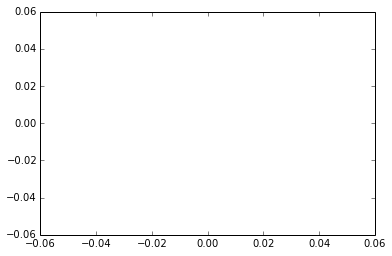

In [22]:
# that was all playing with note values. what about time?

# let's play one note lots of times, constantly speeding up

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# each note for a 10th of a second
note_num = 37 #side stick
note_dur = 0.1

# we'll make 100 notes
num_hits = 100
# starting 1 second apart
delay = 1.0
# reduce delay by some percentage each hit
time_dialation_coefficient = 0.1

# first event at time zero
time = 0.0

events = []

# let's get faster and then slower
for n in range(num_hits):
    pm.instruments[0].notes.append(pretty_midi.Note(75, note_num, time, time + note_dur))
        
    notes.append(time)
    time += delay
    
    # we'll switch directions 1/2 way through...
    if n < num_hits/2:
        delay -= delay * time_dialation_coefficient
    else:
        delay += delay * time_dialation_coefficient

midi_filename = "slow_fast_slow.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

#events is now a list of start times for something or other
print(events)
plt.plot(events)



In [23]:
kill_midi()

[  0.           0.88019795   1.71197412   2.49799231   3.24076977
   3.94268529   4.60598677   5.23279846   5.82512775   6.38487161
   6.91382262   7.41367479   7.8860289    8.3323977    8.75421069
   9.15281874   9.52949842   9.88545606  10.22183162  10.53970237
  10.84008629  11.12394538  11.39218871  11.64567534  11.88521707
  12.11158103  12.32549218  12.52763557  12.71865858  12.89917295
  13.0697568   13.23095643  13.38328808  13.52723961  13.66327202
  13.79182097  13.91329814  14.02809256  14.13657186  14.23908346
  14.33595566  14.42749868  14.51400571  14.59575378  14.6730047
  14.74600585  14.81499105  14.8801812   14.94178509  15.          15.
  15.05821491  15.1198188   15.18500895  15.25399415  15.3269953
  15.40424622  15.48599429  15.57250132  15.66404434  15.76091654
  15.86342814  15.97190744  16.08670186  16.20817903  16.33672798
  16.47276039  16.61671192  16.76904357  16.9302432   17.10082705
  17.28134142  17.47236443  17.67450782  17.88841897  18.11478293
  18.35

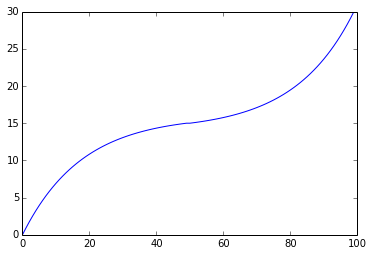

In [24]:
# okay, but that was kinda clunky. Let's generate start times directly

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# each note is a middle C played for a 10th of a second
note_num = 38 #snare
note_dur = 0.1

# generate log-spaced numbers
# np.linspace() generates a linear spacing
# so np.logspace() generate a log spacing, which is often more musically interesting
# from 2^4 to 2^0 (16 to 1)
slow_fast = 16 - np.logspace(4,0,base=2)
fast_slow = 14 + np.logspace(0,4,base=2)

start_times = np.concatenate((slow_fast, fast_slow))


for start in start_times:
    pm.instruments[0].notes.append(pretty_midi.Note(75, note_num, start, start + note_dur))
    

midi_filename = "slow_fast_slow2.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

# plot them as is
plt.plot(start_times)
print start_times



In [25]:
kill_midi()

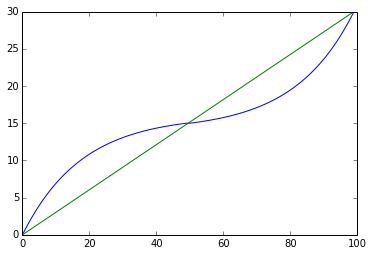

In [26]:
# same thing, but with a linear time drum along side for comparison

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# each note is a middle C played for a 10th of a second
log_note_num = 67 #high agogo
lin_note_num = 68 #low agogo
note_dur = 0.1

# generate log-spaced numbers
# from 2^4 to 2^0 (16 to 1)
slow_fast = 16 - np.logspace(4,0,base=2)
fast_slow = 14 + np.logspace(0,4,base=2)
log_start_times = np.concatenate((slow_fast, fast_slow))
lin_start_times = np.linspace(0,30,100)


for log_start,lin_start in zip(log_start_times, lin_start_times):
    pm.instruments[0].notes.append(pretty_midi.Note(75, log_note_num, log_start, log_start + note_dur))
    pm.instruments[0].notes.append(pretty_midi.Note(75, lin_note_num, lin_start, lin_start + note_dur))

midi_filename = "speedup2.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

# plot them as is
plt.plot(log_start_times)
plt.plot(lin_start_times)


In [27]:
kill_midi()

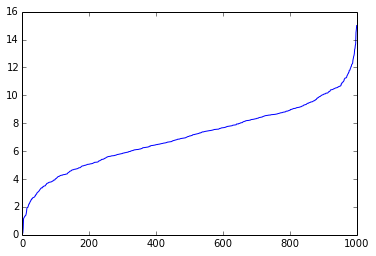

In [29]:
# let's do a normal distribution of drum hit onsets

def get_norm_times(num = 100, duration = 10.0):
    
    # get num normally distributed values
    norm_hits = np.random.randn(num)
    #print norm_hits
    
    # sort them low to high
    norm_hits.sort()
    #print norm_hits
    
    # shift them so that we start at zero
    norm_hits -= norm_hits.min()
    #print norm_hits
    
    # we want to multiply our times by some value
    # so that they cover the total duration
    # last time value * x = duration
    # x = duration / last time value
    time_multi = duration / norm_hits.max()
    norm_hits *= time_multi
    
    return norm_hits

start_times = get_norm_times(1000, 15.0)

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# each note is a 10th of a second
note_num = 76 #wood block
note_dur = 0.1

for time in start_times:
    pm.instruments[0].notes.append(pretty_midi.Note(75, note_num, time, time + note_dur))

midi_filename = "normal_rhythm.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

plt.plot(start_times)
#print start_times

In [30]:
kill_midi()

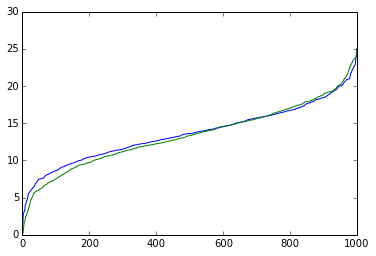

In [31]:
# let's do two drums with different normal distributions

start_times_a = get_norm_times(1000, 25.0)
start_times_b = get_norm_times(1000, 25.0)

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# each note is a middle C played for a 10th of a second
note_num_a = 61 # tom
note_num_b = 60 # tom
note_dur = 0.25

for time_a,time_b in zip(start_times_a,start_times_b):
    pm.instruments[0].notes.append(pretty_midi.Note(75, note_num_a, time_a, time_a + note_dur))
    pm.instruments[1].notes.append(pretty_midi.Note(75, note_num_b, time_b, time_b + note_dur))

midi_filename = "normal_rhythm_double.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

plt.plot(start_times_a)
plt.plot(start_times_b)
#print start_times

In [32]:
kill_midi()

okay, normal is nice, what about something else?
pareto is a one-sided exponential distribution
so we'll get lots of events at the beginning and then a long tail

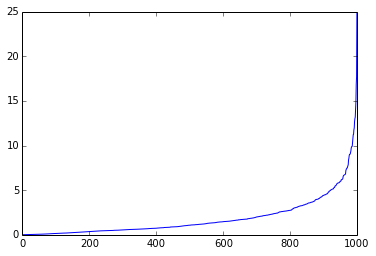

In [33]:
def get_pareto_times(num = 100, duration = 10.0, shape = 5):
    
    # get num pareto distributed values
    pareto_hits = np.random.pareto(shape, num)
    #print pareto_hits
    
    # sort them low to high
    pareto_hits.sort()
    #print norm_hits
    
    # shift them so that we start at zero
    pareto_hits -= pareto_hits.min()
    #print norm_hits
    
    # we want to multiply our times by some value
    # so that they cover the total duration
    time_multi = duration / pareto_hits.max()

    pareto_hits *= time_multi
    
    return pareto_hits

# the shape parameter tells you how sharp the turn is...
start_times = get_pareto_times(1000, 25.0)

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# each note is a middle C played for a 10th of a second
note_num = 61 # tom
note_dur = 0.25

for time in start_times:
    pm.instruments[0].notes.append(pretty_midi.Note(75, note_num, time, time + note_dur))

midi_filename = "pareto_rhythm.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

plt.plot(start_times)
#print start_times


In [34]:
kill_midi()

zipf is a power law type distribution -- small events are most likely, large events least likely. we'll use it to make a crackling sound, with occassional loud bursts. like a log burning!

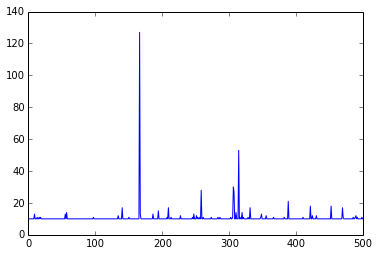

In [35]:

def get_zipf_volumes(num = 100, shape = 2.0):
    
    # get num zipf distributed values
    volumes = np.random.zipf(shape, num)
    
    # find multiplier to shift values from 10-127 for MIDI volume
    normalizer = 117.0/volumes.max()
    volumes *= normalizer
    # now all values are from 0-117, so shift up 10 for 10-127
    volumes += 10
    
    return volumes

# get a bunch of volume values
volumes = get_zipf_volumes(500)

#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add drum
pm.instruments.append(pretty_midi.Instrument(0, is_drum=True))

# our drum sound
note_num = 62 # tom
note_dur = 0.5

# we're generating our time values with linspace. they're independent of our note_dur value. so we can overlap notes if we want...
for time, volume in zip(np.linspace(0.0, 20, len(volumes)), volumes):
    pm.instruments[0].notes.append(pretty_midi.Note(volume, note_num, time, time + note_dur))

midi_filename = "zipf_volumes.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)

plt.plot(volumes)


In [36]:
kill_midi()

Remember the Tom Johnson example, above? We stored the chords in a list called tj_chords. Let's use them to generate a score using Abjad and lilypond, an open source music notation package.

We stored the chords as MIDI values, starting with middle C (MIDI note 60). But abjad uses middle C = 0. So we need to subtract 60 from each element in each chord. Ugh! 

In a normal Python list you can't operate on all members of the list at once. You'd have to iterate through each item in each chord, subtract 60 from it, then store it back in the chord. Luckily numpy knows that this is a pretty common need, so there's a super easy way to do it using a numpy array rather than a Python list. You can generally think of numpy arrays and Python lists as being the same thing. But numpy arrays have a lot of extra functions built in that let you manipulate them in all sorts of useful ways.

In [28]:
# we'll use a numpy array here so that we can do the -= 60 trick
# this line simply copies the Python list tj_chords into a numpy array called np_chords
np_chords = np.array(tj_chords)

# the chords are using MIDI note numbers. but abjad wants middle C = 0
# so we'll just shift everything down by 60
np_chords -= 60

# an abjad Container can take a bunch of chords and display them on a staff
score = abjad.Container()

# we'll create an abjad Chord object for each chord and store it in our score
for chord in np_chords:
    chord = abjad.Chord(chord, abjad.Duration(1, 4))
    score.append(chord)
    
# abjad will use lilypad behind the scenes to create a pdf file and ask our OS to open it for us
abjad.show(score)



Remember above when we generated a bunch of pitches in a normal distribution. We stored them in a list called pitches. Let's make a score!

We stored pitches as numbers from 0-11, so we don't have to shift them down for abjad.

In [29]:
normal_score = abjad.Container()

for pitch in pitches:
    normal_score.append(abjad.Note(pitch, abjad.Duration(1,32)))

abjad.show(normal_score)

Remember the Larry Polansky piece 51 Melodies? It used the idea of 'morphing' one melody into another. Let's see how we might do that.

We'll start with melody A and morph it into melody B. We'll just do the pitches this time, but you could apply this technique to any parameters you want.

To make the process really clear we'll simply morph an ascending C Major scale into a descending C Major scale. We'll iterate through the scale over and over again, each time picking a note to morph. Morphing a note will simply mean moving it one half step closer to the target note.

In [30]:
# nudge one note in current closer to target
def morph_scale_step(target, current):
    
    note_num = random.randint(0,len(target) - 1)
    #print "trying note: ", note_num

    t_note = target[note_num]

    if current[note_num] < t_note:
        current[note_num] += 1
        return True
    elif current[note_num] > t_note:
        current[note_num] -= 1
        return True
    else:
        return False

In [31]:
source_scale = [0, 2, 4, 5, 7, 9, 11, 12]

# WHAT?!?
# this means take the whole list and count through it backwards (-1)
# that gives us the list backwards!
target_scale = source_scale[::-1]

# we want to make a copy of our scale so that we don't modify the original
# this has the same effect as doing:
# curr_scale = source_scale[:]
curr_scale = list(source_scale)

print source_scale
print target_scale
print curr_scale

# we want to store all of our intermediate scales
scales = [source_scale]

while not curr_scale == target_scale:
    got_one = morph_scale_step(target_scale, curr_scale)
    if got_one:
        scales.append(list(curr_scale))
        
#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add guitar
pm.instruments.append(pretty_midi.Instrument(24, is_drum=False))

time = 0.0
note_num = 0 
beat_dur = 0.1
note_dur = beat_dur * 0.9

# create an abjad score container
morph_score = abjad.Container()

for scale in scales:
    for note in scale:
        morph_score.append(abjad.Note(note, abjad.Duration(1, 16)))
        pm.instruments[0].notes.append(pretty_midi.Note(90, note + 60, time, time + note_dur))
        time += beat_dur


abjad.show(morph_score)


midi_filename = "morph_melody.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)


[0, 2, 4, 5, 7, 9, 11, 12]
[12, 11, 9, 7, 5, 4, 2, 0]
[0, 2, 4, 5, 7, 9, 11, 12]


In [32]:
kill_midi()

In [42]:
# come on, we gotta do two at once!
# let's use one-note source/target melodies!

source_scale_a = [0,0,0,0,0,0,0,0]
source_scale_b = [12,12,12,12,12,12,12,12]

target_scale_a = list(source_scale_b)
target_scale_b = list(source_scale_a)

# we want to make a copy of our scale so that we don't modify the original
curr_scale_a = list(source_scale_a)
curr_scale_b = list(source_scale_b)

print source_scale_a
print target_scale_a
print source_scale_b
print target_scale_b

#print curr_scale_a
#print curr_scale_b

# we want to store all of our intermediate scales
scales_a = [source_scale_a]
scales_b = [source_scale_b]

while not curr_scale_a == target_scale_a:
    got_one = morph_scale_step(target_scale_a, curr_scale_a)
    if got_one:
        scales_a.append(list(curr_scale_a))

while not curr_scale_b == target_scale_b:
    got_one = morph_scale_step(target_scale_b, curr_scale_b)
    if got_one:
        scales_b.append(list(curr_scale_b))

#print curr_scale

#print scales

    
#make a pretty midi object
pm = pretty_midi.PrettyMIDI()

#add guitars
pm.instruments.append(pretty_midi.Instrument(24, is_drum=False))
pm.instruments.append(pretty_midi.Instrument(25, is_drum=False))

# our drum sound
time = 0.0
note_num = 0 
beat_dur = 0.15
note_dur = beat_dur * 0.9

morph_score = abjad.Container()

for s_a, s_b in zip(scales_a, scales_b):
    for note_a, note_b in zip(s_a, s_b):
        chord = abjad.Chord([note_a], abjad.Duration(1,8))
        chord.note_heads.append(note_b)
        morph_score.append(chord)
        pm.instruments[0].notes.append(pretty_midi.Note(90, note_a + 60, time, time + note_dur))
        pm.instruments[1].notes.append(pretty_midi.Note(90, note_b + 60, time, time + note_dur))
        time += beat_dur

abjad.show(morph_score)


midi_filename = "morph_melodies.mid"
pm.write(midi_filename)

#let's play it!
play_midi_file(midi_filename)



[0, 0, 0, 0, 0, 0, 0, 0]
[12, 12, 12, 12, 12, 12, 12, 12]
[12, 12, 12, 12, 12, 12, 12, 12]
[0, 0, 0, 0, 0, 0, 0, 0]


In [43]:
kill_midi()